In [7]:
# Imports

import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
path ="/content/drive/MyDrive/2025-2/Machine Learning/proyecto1/"
train_df = pd.read_csv(path + "datos_entrenamiento_riesgo.csv")
test_df = pd.read_csv(path +  "datos_prueba_riesgo.csv")

In [9]:
# EDA
def impute_variables(train_df, test_df):
    categorical_encoded = ['sector_laboral', 'tipo_vivienda', 'nivel_educativo', 'estado_civil']
    for col in categorical_encoded:
        mode_train = train_df[col].mode()[0]
        train_df[col].fillna(mode_train, inplace=True)
        test_df[col].fillna(mode_train, inplace=True)

    numerical = ['porcentaje_utilizacion_credito', 'proporcion_pagos_a_tiempo',
                'residencia_antiguedad_meses', 'lineas_credito_abiertas']
    for col in numerical:
        median_train = train_df[col].median()
        train_df[col].fillna(median_train, inplace=True)
        test_df[col].fillna(median_train, inplace=True)
    return train_df, test_df

def normalize(x_train, x_test):
    scaler = StandardScaler()
    x_train_norm = scaler.fit_transform(x_train)
    x_test_norm = scaler.transform(x_test)
    return x_train_norm, x_test_norm

def add_bias(x):
    return np.column_stack([np.ones(x.shape[0]), x])

def encode_labels(y):
    label_map = {'Bajo': 0, 'Medio': 1, 'Alto': 2}
    return y.map(label_map).values

# Preparar datasets con imputación
train_imputed, test_imputed = impute_variables(train_df.copy(), test_df.copy())

# Separar features y targets
X_train_imputed = train_imputed.drop('nivel_riesgo', axis=1)
X_test_imputed = test_imputed.drop('nivel_riesgo', axis=1)
y_train_imputed = train_imputed['nivel_riesgo']
y_test_imputed = test_imputed['nivel_riesgo']

# Normalize
X_train_norm, X_test_norm = normalize(X_train_imputed, X_test_imputed)

# Agregar Bias
x_train = add_bias(X_train_norm)
x_test = add_bias(X_test_norm)

# Convertir etiquetas
y_train = encode_labels(y_train_imputed)
y_test = encode_labels(y_test_imputed)

/tmp/ipython-input-3812804879.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(mode_train, inplace=True)
/tmp/ipython-input-3812804879.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [10]:
def train(X, Y, alpha, C, epochs):
    w = np.zeros(X.shape[1])
    b = 0
    n = X.shape[0]
    loss = []
    for epoch in range(epochs):
        for i in range(n):
            if Y[i] * (np.dot(X[i], w) + b) < 1:
                w = w - alpha * (w - C * Y[i] * X[i])
                b = b + alpha * C * Y[i]
            else:
                w = w - alpha * w
        loss.append(0.5 * np.dot(w, w) + C * np.mean(np.maximum(0, 1 - Y * (X @ w + b))))
    return w, b, loss

def train_one_vs_rest(X, Y, alpha, C, class_weights, epochs):
    w1, b1, loss1 = train(X, np.where(Y == 0, 1, -1), alpha, C * class_weights[0], epochs)
    w2, b2, loss2 = train(X, np.where(Y == 1, 1, -1), alpha, C * class_weights[1], epochs)
    w3, b3, loss3 = train(X, np.where(Y == 2, 1, -1), alpha, C * class_weights[2], epochs)

    return w1, b1, loss1, w2, b2, loss2, w3, b3, loss3

def predict(score1, score2, score3):
    scores = np.vstack([score1, score2, score3]).T
    return np.argmax(scores, axis=1)

def score(X, W, b):
    return X @ W + b / np.linalg.norm(W)

from sklearn.feature_selection import mutual_info_classif

def information_gain_selection(X_train, y_train, X_test, k):
    mi_scores = mutual_info_classif(X_train, y_train, random_state=42)

    top_k_indices = np.argsort(mi_scores)[-k:]

    X_train_selected = X_train[:, top_k_indices]
    X_test_selected = X_test[:, top_k_indices]

    return X_train_selected, X_test_selected, top_k_indices



In [11]:
# Matriz de confusión
def analyze_results(y_true, y_pred, title="Matriz de Confusión"):
  cm = confusion_matrix(y_true, y_pred)
  class_names = ['Bajo', 'Medio', 'Alto']

  cm_decimal = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(6, 4))
  sns.heatmap(cm_decimal, annot=True, fmt='.3f', cmap='Blues',
              xticklabels=class_names, yticklabels=class_names, cbar=False)

  plt.title(title)
  plt.tight_layout()
  filename = f'{title.replace(" ", "_").replace("-", "_")}_decimal.png'
  plt.show()

def compute_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred) * 100

In [18]:
def test():
    alpha = 0.000001
    epochs = 500

    counts = np.bincount(y_train)
    class_weights = [len(y_train) / (3 * counts[i]) for i in range(3)]

    class_weights[1] = class_weights[1] * 0.16
    class_weights[2] = class_weights[2] * 1.05

    W1, b1, loss1, W2, b2, loss2, W3, b3, loss3 = train_one_vs_rest(x_train, y_train, alpha, 39, class_weights, epochs)
    score1 = score(x_test, W1, b1)
    score2 = score(x_test, W2, b2)
    score3 = score(x_test, W3, b3)

    print("Score promedio clase 0:", np.mean(score1))
    print("Score promedio clase 1:", np.mean(score2))
    print("Score promedio clase 2:", np.mean(score3))

    y_pred = predict(score1, score2, score3)

    analyze_results(y_test, y_pred)

    plt.plot(loss1, label="Low vs resto")
    plt.plot(loss2, label="Medium vs resto")
    plt.plot(loss3, label="High vs resto")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.title("Evolución del loss durante el entrenamiento")
    plt.legend()
    plt.grid(True)
    plt.show()

    # print(classification_report(y_test, y_pred, target_names=['Bajo','Medio','Alto']))
    print("Confusion matrix (raw counts):")
    print(confusion_matrix(y_test, y_pred))

Score promedio clase 0: -0.5597556431662715
Score promedio clase 1: 0.9725406712914635
Score promedio clase 2: -1.197802891377299


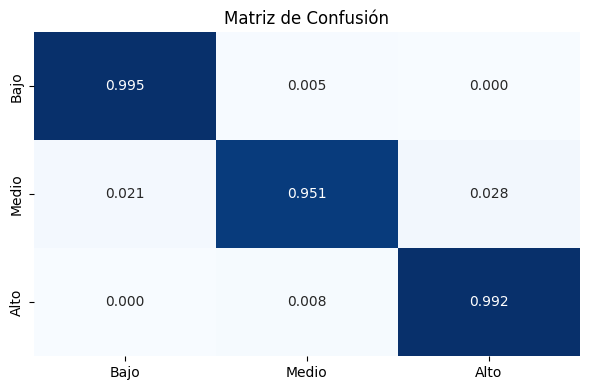

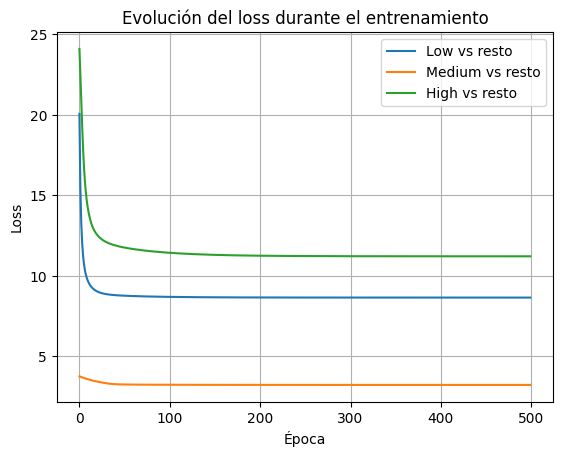

Confusion matrix (raw counts):
[[1525    7    0]
 [  58 2599   76]
 [   0    6  729]]


In [19]:
test()